In [61]:
import numpy as np
from numpy import zeros, eye, array, diag, exp, ones, tanh, cosh, dstack, log, hstack, vstack, sinh
from numpy.linalg import solve, norm
from numpy.random import choice, default_rng, randint, randn
from scipy.stats import multivariate_normal as MVN
from scipy.special import logsumexp, ndtr
from scipy.stats import uniform as udist
import math
import time
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib import rc
from ipywidgets.widgets import IntSlider
from ipywidgets.widgets import interact
from warnings import resetwarnings, catch_warnings, filterwarnings
import seaborn as sns

from Manifolds.GKManifoldNew import GKManifold, data_generator, find_point_on_manifold, find_point_on_manifold_from_θ
from markov_snippets import MSAdaptive, SMCAdaptive
from tangential_hug_functions import TangentialHugSampler
from tangential_hug_functions import HugTangentialMultivariate
from RWM import RWM
from utils import ESS_univariate

In [2]:
seed = 1234
m = 20     # number of latent variables
d = m + 4  # dimensionality of x-component

In [157]:
def generate_settings(
    d=d, 
    N=2000,
    B=20,
    δ=0.01,
    δmin=1e-3,
    δmax=100.0,
    εmin=1e-16,
    min_pm=1e-4,
    maxiter=500,
    verbose=False,
    εs_fixed=None,
    adaptiveε=True,
    adaptiveδ=False,
    z0_manual=None,
    pm_target=0.23,
    pm_switch=0.1,
    prior_seed=seed,
    low_memory=True,
    integrator='rwm',
    εprop_switch=0.01,
    ε0_manual=None,
    quantile_value=0.9,
    initialization='manual',
    switch_strategy='pm',
    kernel='uniform',
    prior_scale=7,
    thinning=10,
    burnin=100,
    use_autograd=False,
    stopping_criterion={'εmin', 'pm'},
    resampling_seed=1234,
    mh_kernel_seed=1234,
    resampling_scheme='multinomial'):
    # here d represents m+4
    # Generate the manifold
    θ0        = array([3.0, 1.0, 2.0, 0.5])       # True parameter value on U(0, 10) scale.
    ystar     = data_generator(θ0, m, seed=seed)  # Observed data
    q         = MVN(zeros(d), eye(d))             # Proposal distribution for THUG
    resetwarnings()
    manifold  = GKManifold(ystar, kernel_type=kernel, use_autograd=use_autograd)
    # grab arguments
    arguments = locals()
    return arguments

In [4]:
def generate_initial_particles(ϵ0, N=5000, s=0.001):
    # Generate Manifold
    θ0        = array([3.0, 1.0, 2.0, 0.5])       # True parameter value on U(0, 10) scale.
    ystar     = data_generator(θ0, m, seed=1234)  # Observed data
    resetwarnings()
    manifold  = GKManifold(ystar, kernel_type='uniform', use_autograd=False, θtrue=θ0)

    # Generate target distribution
    ξ0 = manifold.sample()               # Initial point on manifold                            # Starting epsilon
    logηε0 = manifold.generate_logηε(ε0)  # Target filamentary distribution

    # Sample from it using RWM
    s_rwm, a_rwm = RWM(x0=ξ0, s=s, N=N, logpi=logηε0)

    # Add velocities to particles
    v0_manual = randn(*s_rwm.shape)
    z0_manual = np.hstack((s_rwm, v0_manual))
    return z0_manual

def generate_initial_particles_on_manifold(N=5000, θtrue=False):
    # Generate Manifold
    θ0        = array([3.0, 1.0, 2.0, 0.5])       # True parameter value on U(0, 10) scale.
    ystar     = data_generator(θ0, m, seed=1234)  # Observed data
    resetwarnings()
    manifold  = GKManifold(ystar, kernel_type='uniform', use_autograd=False, θtrue=θ0)
    # Sample N times
    x0_manual = np.vstack([manifold.sample(fromtheta=θtrue) for _ in range(N)])
    v0_manual = randn(*x0_manual.shape)
    return np.hstack((x0_manual, v0_manual))

def generate_particles_on_manifold_then_rwm(ϵ0, N=5000, θtrue=False, δrwm=0.001):
    """First, generate particles on the manifold. Then use RWM to actually sample from a filamentary
    distribution of sorts."""
    # Generate manifold (used only to generate filamentary distribution)
    θ0        = array([3.0, 1.0, 2.0, 0.5])       # True parameter value on U(0, 10) scale.
    ystar     = data_generator(θ0, m, seed=1234)  # Observed data
    manifold  = GKManifold(ystar, kernel_type='uniform', use_autograd=False, θtrue=θ0)
    # Sample on manifold
    on_manifold = generate_initial_particles_on_manifold(N=N, θtrue=θtrue)
    x0_on_manifold = on_manifold[:, :on_manifold.shape[1]//2]
    # Store filamentary samples
    filamentary_samples = []
    for x0 in x0_on_manifold:
        filamentary_samples.append(RWM(x0, s=δrwm, N=1, logpi=manifold.generate_logηε(ϵ0))[0].flatten())
    # Create array
    v0_manual = randn(*x0_on_manifold.shape)
    x0_manual = np.vstack(filamentary_samples)
    return np.hstack((x0_manual, v0_manual))

def sample_from_filamentary(ε0, N=2000, n_per_sample=10, s=1.0, fromtheta=False):
    samples = []
    acceptances = []
    # Generate Manifold
    θ0        = array([3.0, 1.0, 2.0, 0.5])       # True parameter value on U(0, 10) scale.
    ystar     = data_generator(θ0, m, seed=1234)  # Observed data
    resetwarnings()
    manifold  = GKManifold(ystar, kernel_type='uniform', use_autograd=False, θtrue=θ0)
    # Construct filamentary distribution
    logηε0 = manifold.generate_logηε(ε0)
    while len(acceptances) < N:
        with catch_warnings():
            filterwarnings('error')
            try:
                # Sample on the manifold
                ξ0 = manifold.sample(fromtheta=fromtheta)
                # Sample starting from ξ0 and perform 10 steps of RWM. Grab the final point
                s_rwm, a_rwm = RWM(x0=ξ0, s=s, N=n_per_sample, logpi=logηε0)
                samples.append(s_rwm[-1])
                acceptances.append(np.mean(a_rwm)) #int(sum(a_rwm == 1) > 0))
            except RuntimeWarning:
                continue
    print("Acceptance Probability: {:.3f}".format(np.mean(acceptances)*100))
    x0_manual = vstack(samples)
    v0_manual = v0_manual = randn(*x0_manual.shape)
    return hstack((x0_manual, v0_manual))

def sample_from_filamentary_with_thug(ε0, N=2000, n_per_sample=10, s=1.0, fromtheta=False):
    samples = []
    acceptances = []
    # Generate Manifold
    θ0        = array([3.0, 1.0, 2.0, 0.5])       # True parameter value on U(0, 10) scale.
    ystar     = data_generator(θ0, m, seed=1234)  # Observed data
    resetwarnings()
    manifold  = GKManifold(ystar, kernel_type='uniform', use_autograd=False, θtrue=θ0)
    # Construct filamentary distribution
    logηε0 = manifold.generate_logηε(ε0)
    while len(acceptances) < N:
        with catch_warnings():
            filterwarnings('error')
            try:
                # Sample on the manifold
                ξ0 = manifold.sample(fromtheta=fromtheta)
                # Sample starting from ξ0 and perform 10 steps of RWM. Grab the final point
                THUG = TangentialHugSampler(ξ0, T=5*s, B=5, N=N, α=0.0, logpi=logηε0, jac=manifold.fullJacobian)
                s_thug, a_thug = THUG.sample() #(x0=ξ0, s=s, N=n_per_sample, logpi=logηε0)
                samples.append(s_thug[-1])
                acceptances.append(np.mean(a_thug)) #int(sum(a_rwm == 1) > 0))
            except RuntimeWarning:
                continue
    print("Acceptance Probability: {:.3f}".format(np.mean(acceptances)*100))
    x0_manual = vstack(samples)
    v0_manual = v0_manual = randn(*x0_manual.shape)
    return hstack((x0_manual, v0_manual))


In [5]:
N      = 5000
B      = 20
δmin   = 1e-3
min_pm = 1e-4
pm_switch = 0.1
quantile_value = 0.9

In [18]:
# Sample from filamentary distribution
ε0_20 = 20.0
S20 = sample_from_filamentary(ε0=ε0_20, N=N, n_per_sample=2, s=0.5, fromtheta=True)

Acceptance Probability: 14.990


In [22]:
SMC_RT_0001_FIL_Tδ_09 = SMCAdaptive(generate_settings(
        d=d, 
        N=N,
        B=B,
        δ=[0.001, 0.01],
        δmin=δmin,
        min_pm=min_pm,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=False,
        z0_manual=S20,
        pm_target=0.23,
        pm_switch=pm_switch,
        prior_seed=1111,
        low_memory=True,
        integrator='rwm_then_thug',
        εprop_switch=0.01,
        ε0_manual=ε0_20,
        quantile_value=quantile_value,
        initialization='manual',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm'},
        resampling_seed=1234,
        mh_kernel_seed=1234))
_ = SMC_RT_0001_FIL_Tδ_09.sample()

Stochastic Kernel: RWM.
Stopping criterion:  εmin, pm.
Iteration:  1
	Quantile Value:  0.9
	Particles resampled.
	Epsilon: 13.9790414711152540
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.8539000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  2
	Quantile Value:  0.9
	Particles resampled.
	Epsilon: 10.3021514168185409
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.8463000000000001
	Step-size kept fixed at: 0.0010000000000000
Iteration:  3
	Quantile Value:  0.9
	Particles resampled.
	Epsilon: 5.2019425120653864
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.8503000000000001
	Step-size kept fixed at: 0.0010000000000000
Iteration:  4
	Quantile Value:  0.9
	Particles resampled.
	Epsilon: 3.0966423476643214
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.7799000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  5
	Quantile Value:  0.9
	Particles resampled.
	Epsilon: 2.6

	Epsilon: 0.7811674448628589
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1485000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  39
	Quantile Value:  0.9
	Particles resampled.
	Epsilon: 0.7705788238390949
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1403000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  40
	Quantile Value:  0.9
	Particles resampled.
	Epsilon: 0.7576743005176161
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1351000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  41
	Quantile Value:  0.9
	Particles resampled.
	Epsilon: 0.7468119682586581
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1252000000000000
	Step-size kept fixed at: 0.0010000000000000
Iteration:  42
	Quantile Value:  0.9
	Particles resampled.
	Epsilon: 0.7352656311414720
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.1249000000000000
	Step-siz

	Epsilon: 0.5053950893346806
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.4290000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  76
	Quantile Value:  0.9
	Particles resampled.
	Epsilon: 0.5004158399308978
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.4247000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  77
	Quantile Value:  0.9
	Particles resampled.
	Epsilon: 0.4958345281414863
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.4170000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  78
	Quantile Value:  0.9
	Particles resampled.
	Epsilon: 0.4913713026794345
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.4149000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  79
	Quantile Value:  0.9
	Particles resampled.
	Epsilon: 0.4873616280496137
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.3992000000000000
	Step-siz

	Epsilon: 0.3690076278615257
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.3117000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  114
	Quantile Value:  0.9
	Particles resampled.
	Epsilon: 0.3670140232784810
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.3086000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  115
	Quantile Value:  0.9
	Particles resampled.
	Epsilon: 0.3648647902917630
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2976000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  116
	Quantile Value:  0.9
	Particles resampled.
	Epsilon: 0.3629465060046328
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2998000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  117
	Quantile Value:  0.9
	Particles resampled.
	Epsilon: 0.3611661790911511
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2933000000000000
	Step

	Mutation step done.
	Approx AP: 0.2056000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  151
	Quantile Value:  0.9
	Particles resampled.
	Epsilon: 0.3187638390160487
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2077000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  152
	Quantile Value:  0.9
	Particles resampled.
	Epsilon: 0.3177892200269889
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2013000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  153
	Quantile Value:  0.9
	Particles resampled.
	Epsilon: 0.3169422038623363
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2048000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  154
	Quantile Value:  0.9
	Particles resampled.
	Epsilon: 0.3161401878435741
	Weights computed and normalised.
	Mutation step done.
	Approx AP: 0.2020999999999999
	Step-size kept fixed at: 0.0100000000000000
Iteration:  155
	Quanti

# Testing Samplers

In [65]:
def test_rwm(ε0, N, s=0.1):
    """Runs RWM to target filamentary distribution."""
    # Generate Manifold
    θ0        = array([3.0, 1.0, 2.0, 0.5])       # True parameter value on U(0, 10) scale.
    ystar     = data_generator(θ0, m, seed=1234)  # Observed data
    manifold  = GKManifold(ystar, kernel_type='uniform', use_autograd=False, θtrue=θ0)
    
    # Generate filamentary distribution
    logηε0 = manifold.generate_logηε(ε0)
    
    # Find point on manifold
    ξ0 = manifold.sample(fromtheta=True)
    
    # Run RWM
    samples, acceptances = RWM(ξ0, s=s, N=N, logpi=logηε0)
    print("AP: {:.5f}".format(np.mean(acceptances)*100))
    return samples


def test_thug(ε0, N, s=0.1, B=10):
    """Runs RWM to target filamentary distribution."""
    # Generate Manifold
    θ0        = array([3.0, 1.0, 2.0, 0.5])       # True parameter value on U(0, 10) scale.
    ystar     = data_generator(θ0, m, seed=1234)  # Observed data
    manifold  = GKManifold(ystar, kernel_type='uniform', use_autograd=False, θtrue=θ0)
    
    # Generate filamentary distribution
    logηε0 = manifold.generate_logηε(ε0)
    
    # Find point on manifold
    ξ0 = manifold.sample(fromtheta=True)
    
    # Run RWM
    THUGSampler = TangentialHugSampler(ξ0, T=B*s, B=B, N=N, α=0.0, logpi=logηε0, jac=manifold.fullJacobian)
    samples, acceptances = THUGSampler.sample()
    print("AP: {:.5f}".format(np.mean(acceptances)*100))
    return samples

def test_thug2(ε0, N, s=0.1, B=10):
    """Runs RWM to target filamentary distribution."""
    # Generate Manifold
    θ0        = array([3.0, 1.0, 2.0, 0.5])       # True parameter value on U(0, 10) scale.
    ystar     = data_generator(θ0, m, seed=1234)  # Observed data
    manifold  = GKManifold(ystar, kernel_type='uniform', use_autograd=False, θtrue=θ0)
    
    # Generate filamentary distribution
    logηε0 = manifold.generate_logηε(ε0)
    
    # Find point on manifold
    ξ0 = manifold.sample(fromtheta=True)
    
    # Proposal 
    q = MVN(zeros(len(ξ0)), ones(len(ξ0)))
    
    # Run RWM
    samples, acceptances = HugTangentialMultivariate(ξ0, T=B*s, B=B, N=N, α=0, q=q, logpi=logηε0, jac=manifold.fullJacobian)
    print("AP: {:.5f}".format(np.mean(acceptances)*100))
    return samples

### RWM

In [70]:
OUT_RWM20 = test_rwm(ε0=20, N=10000, s=0.01)

AP: 96.09000


In [71]:
OUT_RWM10 = test_rwm(ε0=10, N=10000, s=0.01)

AP: 92.97000


In [72]:
OUT_RWM5 = test_rwm(ε0=5, N=10000, s=0.01)

AP: 87.06000


In [73]:
OUT_RWM1 = test_rwm(ε0=1, N=10000, s=0.01)

AP: 31.27000


In [74]:
OUT_RWM01 = test_rwm(ε0=0.1, N=10000, s=0.01)

AP: 0.10000


In [75]:
OUT_RWM001 = test_rwm(ε0=0.01, N=10000, s=0.01)

AP: 0.00000


### THUG

In [69]:
OUT_THUG20 = test_thug(ε0=20, N=10000, s=0.01, B=5)

AP: 90.53000


In [68]:
OUT_THUG10 = test_thug(ε0=10, N=10000, s=0.01, B=5)

AP: 91.07000


In [67]:
OUT_THUG5 = test_thug(ε0=5, N=10000, s=0.01, B=5)

AP: 90.99000


In [59]:
OUT_THUG1 = test_thug(ε0=1, N=10000, s=0.01, B=10)

AP: 82.09000


In [58]:
OUT_THUG01 = test_thug(ε0=0.1, N=10000, s=0.01, B=10)

AP: 18.33000


In [60]:
OUT_THUG001 = test_thug(ε0=0.01, N=10000, s=0.01, B=10)

AP: 0.05000


In [66]:
OUT_THUG001_2 = test_thug2(ε0=0.01, N=10000, s=0.01, B=10)

AP: 0.05000


# Resampling

In [187]:
SOMETHING = MSAdaptive(generate_settings(
        d=d, 
        N=5000,
        B=B,
        δ=0.01,
        δmin=δmin,
        min_pm=min_pm,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=False,
        z0_manual=None,
        pm_target=0.23,
        pm_switch=pm_switch,
        prior_seed=1111,
        low_memory=True,
        integrator='rwm',
        εprop_switch=0.01,
        ε0_manual=None,
        quantile_value=0.5,
        initialization='prior',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm'},
        resampling_seed=1234,
        mh_kernel_seed=1234,
        resampling_scheme='systematic'))
_ = SOMETHING.sample()

Integrator: RWM.
Stopping criterion:  εmin, pm.
Setting initial epsilon to εmax = 2530215592974.9248046875000000
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 26533.7574199330774718
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8036000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 523.4121327192124227
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9526000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 89.3471706233462442
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9524000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  4
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 41.5471808617556562
	Weights computed and normalized.
	Particle

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8070000000000001
	Step-size kept fixed at: 0.0100000000000000
Iteration:  35
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.8370678707399311
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8110000000000001
	Step-size kept fixed at: 0.0100000000000000
Iteration:  36
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.6925557980221226
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8052000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  37
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.5346689761908747
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8296000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  38
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.3662615010277430
	Wei

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4242000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  68
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.0581543317072113
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4088000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  69
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.0299759419860126
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4000000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  70
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.0020043821009039
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3874000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  71
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.9752307682253450
	Wei

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0446000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  101
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.5053503445106092
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0396000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  102
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4986266091637626
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0328000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  103
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4917430176883070
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0224000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  104
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.4850105614349237


In [188]:
SOMETHING2 = MSAdaptive(generate_settings(
        d=d, 
        N=5000,
        B=B,
        δ=0.01,
        δmin=δmin,
        min_pm=min_pm,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=False,
        z0_manual=None,
        pm_target=0.23,
        pm_switch=pm_switch,
        prior_seed=1111,
        low_memory=True,
        integrator='rwm',
        εprop_switch=0.01,
        ε0_manual=None,
        quantile_value=0.5,
        initialization='prior',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm'},
        resampling_seed=1234,
        mh_kernel_seed=1234,
        resampling_scheme='multinomial'))
_ = SOMETHING2.sample()

Integrator: RWM.
Stopping criterion:  εmin, pm.
Setting initial epsilon to εmax = 2530215592974.9248046875000000
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 26533.7574199330774718
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7782000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 496.5262376630601580
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9508000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 87.4223358885503359
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9496000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  4
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 42.3269224925861351
	Weights computed and normalized.
	Particle

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8040000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  35
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 4.0456609481195169
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7884000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  36
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.9233067523896623
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7974000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  37
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.7847363363999809
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7962000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  38
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.6246265909826434
	Wei

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3204000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  68
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.9228899349651524
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2990000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  69
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8997604677808763
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.3010000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  70
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8786956548061988
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.2814000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  71
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8601187643517270
	Wei

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0390000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  101
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3649400376071349
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0368000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  102
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3574436747054132
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0228000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  103
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3495004667621865
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.0152000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  104
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.3417508789105776


In [220]:
SOMETHING3 = MSAdaptive(generate_settings(
        d=d, 
        N=5000,
        B=B,
        δ=0.01,
        δmin=δmin,
        min_pm=min_pm,
        verbose=True,
        εs_fixed=None,
        adaptiveε=True,
        adaptiveδ=False,
        z0_manual=None,
        pm_target=0.23,
        pm_switch=pm_switch,
        prior_seed=1111,
        low_memory=True,
        integrator='rwm_then_thug',
        εprop_switch=0.01,
        ε0_manual=None,
        quantile_value=0.5,
        initialization='prior',
        switch_strategy='pm',
        kernel='uniform',
        use_autograd=False,
        stopping_criterion={'εmin', 'pm'},
        resampling_seed=1234,
        mh_kernel_seed=1234,
        resampling_scheme='systematic'))
_ = SOMETHING3.sample()

Integrator: RWM.
Stopping criterion:  εmin, pm.
Resampling: SYSTEMATIC.
Setting initial epsilon to εmax = 2530215592974.9248046875000000
Iteration:  1
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 26533.7574199330774718
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7942000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  2
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 542.2422203324617840
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9520000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  3
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 89.7451291016806749
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9552000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  4
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 42.4833321150171557
	Weights computed a

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7616000000000001
	Step-size kept fixed at: 0.0100000000000000
Iteration:  34
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.8322720404578647
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7880000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  35
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.7273368141536736
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7772000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  36
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.6315005639887210
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7688000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  37
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 3.5384370697669554
	Wei

	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4638000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  67
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.3280848205613451
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4718000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  68
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.2970774292928990
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4748000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  69
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.2683007322294100
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.4570000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  70
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 1.2397172599979758
	Wei

	Trajectories constructed.
	Epsilon: 0.9328325254516505
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9414000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  100
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.9252407122524331
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9366000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  101
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.9184613746892751
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9338000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  102
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.9122601611485697
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9388000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  103
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 0.8104080436318637
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9166000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  133
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8088349190877597
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9192000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  134
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8072876834549340
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9248000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  135
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.8058798632061772
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.9198000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  136
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 0.7900146147456845
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8574000000000001
	Step-size kept fixed at: 0.0100000000000000
Iteration:  166
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7898029218154348
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8282000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  167
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7896376545681176
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8312000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  168
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7895024888759397
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8190000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  169
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 0.7860435813606816
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8142000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  199
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7859400453518859
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8284000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  200
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7858403825177300
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8172000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  201
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7857448763916222
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8218000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  202
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 0.7824900589035908
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8306000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  232
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7824057761557663
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8220000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  233
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7823254276927329
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8238000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  234
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7822332452509551
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8352000000000001
	Step-size kept fixed at: 0.0100000000000000
Iteration:  235
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 0.7794658065229736
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8190000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  265
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7793884030344616
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8266000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  266
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7793093971644267
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8308000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  267
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7792366217999509
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8254000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  268
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 0.7768673412925799
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8188000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  298
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7767872159516278
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8179999999999999
	Step-size kept fixed at: 0.0100000000000000
Iteration:  299
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7767084288966710
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8139999999999999
	Step-size kept fixed at: 0.0100000000000000
Iteration:  300
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7766356859797235
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8188000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  301
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 0.7744297835225874
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8194000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  331
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7743649876626595
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8102000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  332
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7743023240585416
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8196000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  333
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7742341209492147
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8208000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  334
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 0.7718886245203982
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8010000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  364
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7718257125935075
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8016000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  365
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7717663525380256
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8078000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  366
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7717045790398891
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8096000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  367
	Quantile Value:  0.5


	Trajectories constructed.
	Epsilon: 0.7696162779553668
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.7998000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  397
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7695616952259401
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8136000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  398
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7695015293171890
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8208000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  399
	Quantile Value:  0.5
	Trajectories constructed.
	Epsilon: 0.7694365297280150
	Weights computed and normalized.
	Particles Resampled.
	Velocities refreshed.
	Prop Moved: 0.8114000000000000
	Step-size kept fixed at: 0.0100000000000000
Iteration:  400
	Quantile Value:  0.5


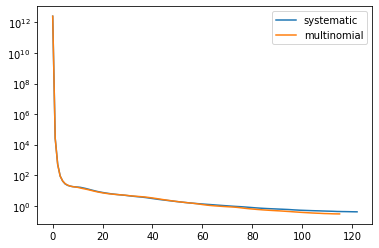

In [221]:
fig, ax = plt.subplots()
ax.plot(SOMETHING.εs, label='systematic')
ax.plot(SOMETHING2.εs, label='multinomial')
ax.set_yscale('log')
ax.legend()
plt.show()

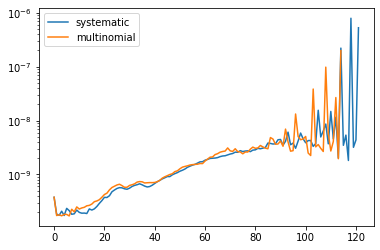

In [252]:
fig, ax = plt.subplots()
ax.plot(SOMETHING.Wbar[1:].var(axis=1), label='systematic')
ax.plot(SOMETHING2.Wbar[1:].var(axis=1), label='multinomial')
# ax.plot(SOMETHING3.εs[1:], SOMETHING3.Wbar[1:].var(axis=1), label='MS-RT')
ax.set_yscale('log')
# ax.set_xscale('log')
ax.legend()
plt.show()

In [251]:
SOMETHING.resampling_scheme

'systematic'

# adagrad

In [255]:
initial_point

NameError: name 'initial_point' is not defined

In [270]:
def adagrad(f, J, x0, lr=0.05, epsilon=1e-8, max_iter=10000):
    x = np.array(x0)
    grad_squared_sum = np.zeros_like(x)
    
    for _ in range(max_iter):
        grad = J(x)
        grad_squared_sum += grad**2
        x -= (lr / (np.sqrt(grad_squared_sum) + epsilon)) * grad
        
        if np.linalg.norm(grad) < epsilon:
            break
    
    return x

# Example usage
function = lambda x: x[0]**2 + x[1]**2  # Define your function f
jacobian = lambda x: np.array([2 * x[0], 2 * x[1]])  # Define the Jacobian of f

initial_point = [1.0, 1.0]  # Initial point
result = adagrad(function, jacobian, initial_point)

print("Optimized point:", result)
print("Function value at optimized point:", function(result))

Optimized point: [3.48461092e-09 3.48461092e-09]
Function value at optimized point: 2.4285026504824193e-17
